

The project consists of using a CNN, specifically a simplification of LeNet-5 to identify ships, the data was obtained from the planet database and published in kaggle by Bob Hammell under the CC BY-SA 4.0 license, which allows its use and transformation
##LeNet-5 Map

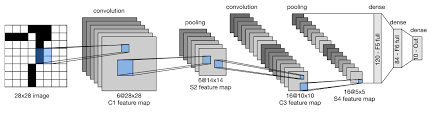

In [30]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
plt.style.use('seaborn')

import torch 
from torchvision import transforms, datasets

from sklearn.model_selection import train_test_split
import json

In [31]:
def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]

In [32]:
f = open('dataset/shipsnet.json')
dataset = json.load(f)
f.close()

In [33]:
X = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')
print(X.shape)
print(y.shape)

(2800, 19200)
(2800,)


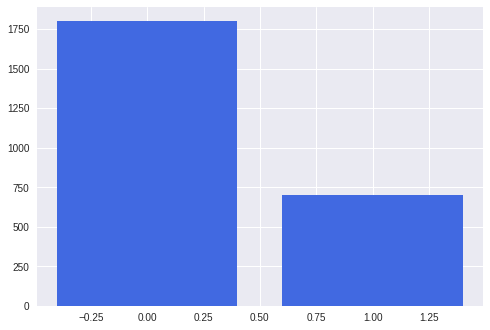

In [34]:
X = X[:2500]
y = y[:2500]

width = 80
height = 80
X = X.reshape([-1, 3, width, height])

unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts, color='royalblue')
plt.show()

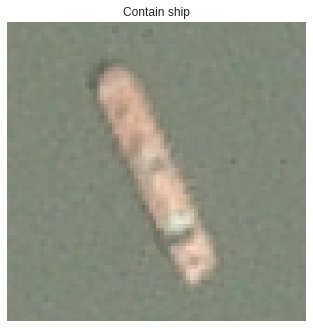

In [35]:
dic={0:'Does not contain ship',1:'Contain ship'}
sample = 13
plt.imshow(X[sample].transpose([1,2,0]))
plt.title(dic[y[sample]])
plt.axis('off')
plt.show()

# 3.
## Data separation

In [13]:
X = X/255.0
y = to_categorical(y, 2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.Tensor([x for x in X_train])
y_train = torch.Tensor([x for x in y_train])

X_test = torch.Tensor([x for x in X_test])
y_test = torch.Tensor([x for x in y_test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """


# 4.   
## Definition, training and evaluation of neural network

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(4624, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.dropout(x)
        
        x = x.view(-1, 4624)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = F.softmax(x,dim=1)
        return x      

net = Net()
print(net) 

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4624, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [16]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.MSELoss()

In [17]:
epochs = 50
batch_size = 30
for epoch in range(epochs):
    for i in tqdm(range(0, len(X_train), batch_size)):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
print(loss)

100%|██████████| 67/67 [00:04<00:00, 15.81it/s]

tensor(0.0379, grad_fn=<MseLossBackward0>)


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(X_test))):
        real_class = torch.argmax(y_test[i])
        net_out = net(X_test[i].view(-1,3,80,80))[0]
        predicted_class = torch.argmax(net_out)
        if (predicted_class == real_class):
            correct += 1
        total += 1
print('Accuracy:', round(correct/total, 3))


100%|██████████| 500/500 [00:00<00:00, 548.22it/s]


Accuracy: 0.9


# 5.
## Inferencia.
For the inference we will use scenes obtained from the Planet API, the script used to analyze the scene was based on the one published by the user Vitali Burachonok in kaggle,[kaggle](https://www.kaggle.com/byrachonok/keras-for-search-ships-in-satellite-image), it consists of:

* We load the scene, image   
* $cutting(x,y)$: 
returns the square with the lower left vertex at (x,y), with 80 pixels per side.
* $not\_near(x,y,coordinates)$: eturns false if there is already a previously registered square containing a ship, which overlaps with the current(lower left vertex(x,y)).
* We iterate in the pixels of the image with step size $step=10$, in each iteration we cut a square using the $cutting$ function, in case of finding a ship we load the image and save the coordinates.
* $show\_ship(x,y,thickness=5)$: 
modifies the image making an empty white square with bottom left corner at $(x,y)$, length $80$ pixels and side width $thickness=5$.

In [19]:
picture_tensor = mpimg.imread('/scene/sf_1.png')
picture_tensor *= 255
picture_tensor = picture_tensor.astype('uint8')
height,width = picture_tensor.shape[:2]
picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor.shape

(4, 659, 351)

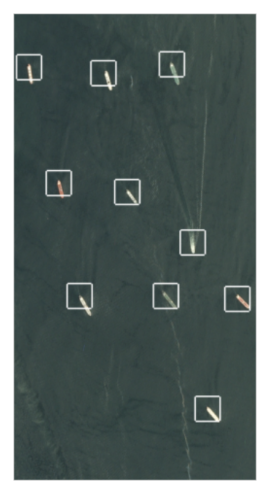

In [20]:
plt.figure(1, figsize = (15, 30))
plt.subplot(3, 1, 1)
plt.imshow(picture_tensor.transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [21]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study/255
    return area_study

In [22]:
def not_near(x, y, coordinates):
    result = True
    s = 80
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [23]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step)):
        area = cutting(x*step, y*step)
        result = net(torch.Tensor(area))
        if result[0][1] > 0.9 and not_near(x*step,y*step, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0].transpose(1, 2, 0))
            plt.axis('off')
            plt.show()

In [24]:
def show_ship(x, y, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

In [25]:
for e in coordinates:
    show_ship(e[0][0], e[0][1])

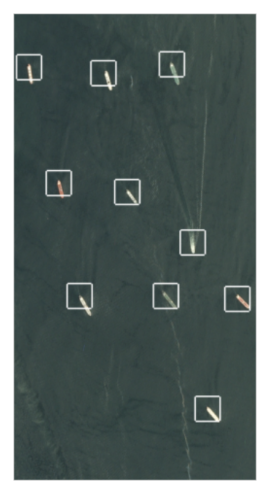

In [26]:
plt.figure(1, figsize = (15, 30))
plt.subplot(3, 1, 1)
plt.imshow(picture_tensor.transpose(1, 2, 0))
plt.axis('off')
plt.show()

# 6.
## Comentario

An accuracy of 95% was obtained using the test data, this is because a convolutional network and dropout were used to avoid overfitting, a simplification of the LeNet-5 architecture was used, this type of network is efficient in classification problems. of pictures. Something that can be done to improve the model is to implement data argumentation since there are only 2500 images in total.